<a href="https://colab.research.google.com/github/BarathSrinivasan2002/Deep_Learning_Face_mask_detection/blob/main/SOA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/BarathSrinivasan2002/Deep_Learning_Face_mask_detection.git

Cloning into 'Deep_Learning_Face_mask_detection'...
remote: Enumerating objects: 1830, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 1830 (delta 56), reused 50 (delta 20), pack-reused 1715 (from 2)
Receiving objects: 100% (1830/1830), 404.09 MiB | 16.80 MiB/s, done.
Resolving deltas: 100% (891/891), done.


In [2]:
%cd Deep_Learning_Face_mask_detection

/content/Deep_Learning_Face_mask_detection


In [3]:
!ls

face-mask-detection	      requirements.txt		 Supervised_Learning_with_Best_Params.ipynb
labels.csv		      sam_v4.ipynb		 Unsupervised_learning_autoencoders.ipynb
Preprocessing_Pipeline.ipynb  SOA_Model.ipynb
README.md		      Supervised_Learning.ipynb


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pickle

# Use full path to the file
with open('/content/drive/MyDrive/DeepLearningFinalProj/Deep_Learning_Face_mask_detection/pipeline.pkl', 'rb') as f:
    pipeline_data = pickle.load(f)

face_images = pipeline_data['face_images']
face_labels = pipeline_data['face_labels']

In [8]:
# Data Augmentation
augmentation = ImageDataGenerator(
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=25,
    fill_mode='nearest'
)

# Splitting Data
train_x, test_val_x, train_y, test_val_y = train_test_split(face_images, face_labels, test_size=0.3, stratify=face_labels)
test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, test_size=0.5, stratify=test_val_y)

train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)
test_y = to_categorical(test_y, num_classes=3)

In [9]:
print(f"Train: {train_x.shape}, Validation: {val_x.shape}, Test: {test_x.shape}")

Train: (2850, 224, 224, 3), Validation: (611, 224, 224, 3), Test: (611, 224, 224, 3)


In [10]:
### Model 1: MobileNetV2
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet.trainable = False  # Freeze base model

model_mobilenet = Sequential([
    mobilenet,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_mobilenet.summary())

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 8,028,675 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [11]:
# Training MobileNet
history_mobilenet = model_mobilenet.fit(
    augmentation.flow(train_x, train_y, batch_size=32),
    validation_data=(val_x, val_y),
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 396ms/step - accuracy: 0.7194 - loss: 5.7266 - val_accuracy: 0.8740 - val_loss: 0.3188
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - accuracy: 0.8079 - loss: 0.4951 - val_accuracy: 0.8756 - val_loss: 0.3067
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.8331 - loss: 0.4055 - val_accuracy: 0.9133 - val_loss: 0.2520
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 302ms/step - accuracy: 0.8351 - loss: 0.3851 - val_accuracy: 0.8871 - val_loss: 0.2995
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 302ms/step - accuracy: 0.8339 - loss: 0.4030 - val_accuracy: 0.8953 - val_loss: 0.2779
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.8380 - loss: 0.3559 - val_accuracy: 0.8887 - val_loss: 0.2856
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 301ms/step - accuracy: 0.8529 - loss: 0.3408 - val_accuracy: 0.9231 - val_loss: 0.2546
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.8640 - loss: 0.3208 - val_accu

In [12]:
base_eval = model_mobilenet.evaluate(test_x, test_y)
print(f"MobileNetV2 (base) Test Accuracy: {base_eval[1]:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8883 - loss: 0.3426
MobileNetV2 (base) Test Accuracy: 0.8985


In [13]:
### Model 2: MobileNetV2 Trained from Scratch (No Pretrained Weights)
mobilenet_scratch = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
mobilenet_scratch.trainable = True  # All layers trainable

model_mobilenet_scratch = Sequential([
    mobilenet_scratch,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_mobilenet_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_mobilenet_scratch.summary())

# Train from Scratch
history_mobilenet_scratch = model_mobilenet_scratch.fit(
    augmentation.flow(train_x, train_y, batch_size=32),
    validation_data=(val_x, val_y),
    epochs=10
)

# Evaluate
scratch_eval = model_mobilenet_scratch.evaluate(test_x, test_y)
print(f"MobileNetV2 (Scratch) Test Accuracy: {scratch_eval[1]:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 10,252,547 (39.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

None
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 90s 537ms/step - accuracy: 0.6994 - loss: 6.0153 - val_accuracy: 0.7938 - val_loss: 0.9377
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 310ms/step - accuracy: 0.8023 - loss: 0.5795 - val_accuracy: 0.7938 - val_loss: 0.7162
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.7754 - loss: 0.5903 - val_accuracy: 0.7938 - val_loss: 0.6402
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 316ms/step - accuracy: 0.7989 - loss: 0.4989 - val_accuracy: 0.7938 - val_loss: 0.7435
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 308ms/step - accuracy: 0.7865 - loss: 0.5088 - val_accuracy: 0.7938 - val_loss: 0.6272
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.7663 - loss: 0.4704 - val_accuracy: 0.7938 - val_loss: 0.6899
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 312ms/step - accuracy: 0.7909 - loss: 0.4249 - val_accuracy: 0.7938 - val_loss: 0.7394
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 305ms/step - accuracy: 0.7900 - loss: 0.4421 - val

In [14]:
### Model 3: Fine-Tune MobileNetV2 (Unfreeze Some Layers)
# Reload MobileNetV2 with pretrained weights
mobilenet_finetune = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 20 layers for fine-tuning
mobilenet_finetune.trainable = True
for layer in mobilenet_finetune.layers[:-20]:
    layer.trainable = False  # Freeze all except last 20 layers

model_mobilenet_finetune = Sequential([
    mobilenet_finetune,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_mobilenet_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
print(model_mobilenet_finetune.summary())

# Train with Fine-Tuning
history_mobilenet_finetune = model_mobilenet_finetune.fit(
    augmentation.flow(train_x, train_y, batch_size=32),
    validation_data=(val_x, val_y),
    epochs=10
)

# Evaluate
finetune_eval = model_mobilenet_finetune.evaluate(test_x, test_y)
print(f"MobileNetV2 (Fine-Tuned) Test Accuracy: {finetune_eval[1]:.4f}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 9,234,755 (35.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

None
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 398ms/step - accuracy: 0.8179 - loss: 0.7888 - val_accuracy: 0.8871 - val_loss: 0.4264
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - accuracy: 0.9097 - loss: 0.2717 - val_accuracy: 0.9165 - val_loss: 0.3917
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.9189 - loss: 0.2500 - val_accuracy: 0.9214 - val_loss: 0.2775
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - accuracy: 0.9375 - loss: 0.1748 - val_accuracy: 0.9280 - val_loss: 0.2518
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.9462 - loss: 0.1639 - val_accuracy: 0.9313 - val_loss: 0.2554
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.9541 - loss: 0.1332 - val_accuracy: 0.9345 - val_loss: 0.2516
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - accuracy: 0.9556 - loss: 0.1277 - val_accuracy: 0.9345 - val_loss: 0.2661
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.9517 - loss: 0.1359 - val

In [15]:
# Evaluating Models
base_eval = model_mobilenet.evaluate(test_x, test_y)
scratch_eval = model_mobilenet_scratch.evaluate(test_x, test_y)
finetune_eval = model_mobilenet_finetune.evaluate(test_x, test_y)

print(f"MobileNetV2 (base) Test Accuracy: {base_eval[1]:.4f}")
print(f"MobileNetV2 (Scratch) Test Accuracy: {scratch_eval[1]:.4f}")
print(f"MobileNetV2 (Fine-Tuned) Test Accuracy: {finetune_eval[1]:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8883 - loss: 0.3426
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7899 - loss: 0.7086
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9308 - loss: 0.3464
MobileNetV2 (base) Test Accuracy: 0.8985
MobileNetV2 (Scratch) Test Accuracy: 0.7938
MobileNetV2 (Fine-Tuned) Test Accuracy: 0.9394


In [16]:
### Optimized AutoML Hyperparameter Tuning with Keras Tuner
!pip install keras-tuner -q
from kerastuner import RandomSearch
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf

def build_model(hp):
    # Define tunable hyperparameters with reduced search space
    model = Sequential([
        MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
        GlobalAveragePooling2D(),  # More efficient than Flatten()
        Dense(units=hp.Int('dense_units', 64, 128, step=64), activation='relu'),
        Dropout(rate=hp.Float('dropout_rate', 0.2, 0.4, step=0.1)),  # Narrower range
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-3, 1e-4])  # Fewer choices
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Reduced from 5
    executions_per_trial=1,  # No redundant runs
    directory='tuner_results',
    project_name='face_mask_detection_optimized'
)

# Run the search with early stopping
tuner.search(
    train_x, train_y,  # Using raw data (no augmentation during search)
    batch_size=32,
    validation_data=(val_x, val_y),
    epochs=5,  # Reduced from 10
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_accuracy')
    ]
)

# Get and evaluate best model
best_model = tuner.get_best_models(num_models=1)[0]
print("\nEvaluating Best Model on Test Set:")
test_loss, test_acc = best_model.evaluate(test_x, test_y)
print(f"\nBest Model Test Accuracy: {test_acc:.4f}")

# Display best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print("\nBest Hyperparameters:")
print(f"- Dense Units: {best_hps.get('dense_units')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

Trial 3 Complete [00h 01m 54s]
val_accuracy: 0.7954173684120178

Best val_accuracy So Far: 0.9214402437210083
Total elapsed time: 00h 05m 37s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating Best Model on Test Set:
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9117 - loss: 0.3002

Best Model Test Accuracy: 0.9165

Best Hyperparameters:
- Dense Units: 64
- Dropout Rate: 0.2
- Learning Rate: 0.0001


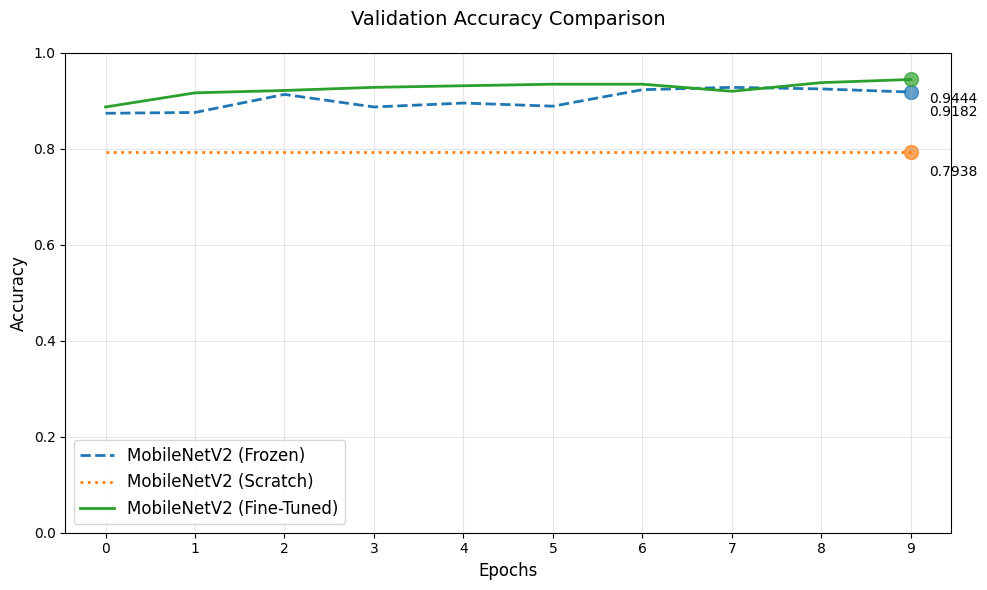

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot validation accuracies
plt.plot(history_mobilenet.history['val_accuracy'],
         label='MobileNetV2 (Frozen)', linestyle='--', linewidth=2)
plt.plot(history_mobilenet_scratch.history['val_accuracy'],
         label='MobileNetV2 (Scratch)', linestyle=':', linewidth=2)
plt.plot(history_mobilenet_finetune.history['val_accuracy'],
         label='MobileNetV2 (Fine-Tuned)', linewidth=2)

# Customize plot
plt.title('Validation Accuracy Comparison', fontsize=14, pad=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(range(0, 10))  # Assuming 10 epochs
plt.ylim(0, 1.0)  # Full accuracy range
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Annotate final accuracy values
for history, label in zip([history_mobilenet, history_mobilenet_scratch, history_mobilenet_finetune],
                         ['Frozen', 'Scratch', 'Fine-Tuned']):
    final_acc = history.history['val_accuracy'][-1]
    plt.scatter(9, final_acc, s=100, alpha=0.7)
    plt.text(9.2, final_acc-0.05, f'{final_acc:.4f}', fontsize=10)

plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step


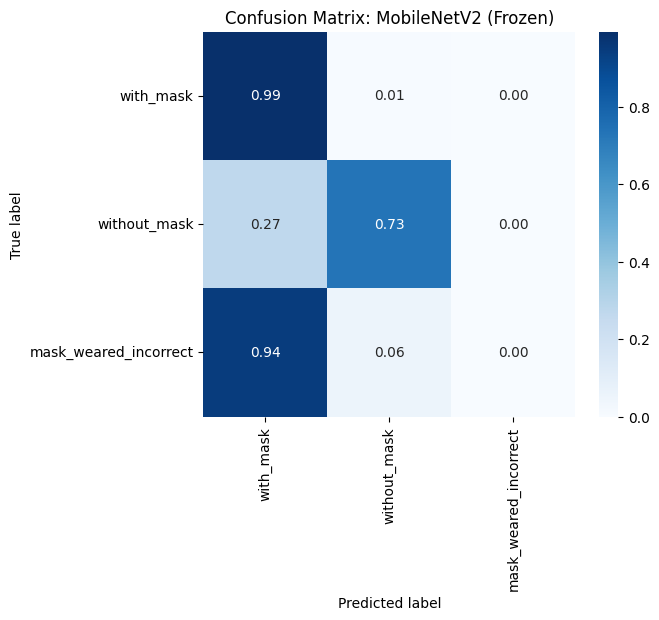

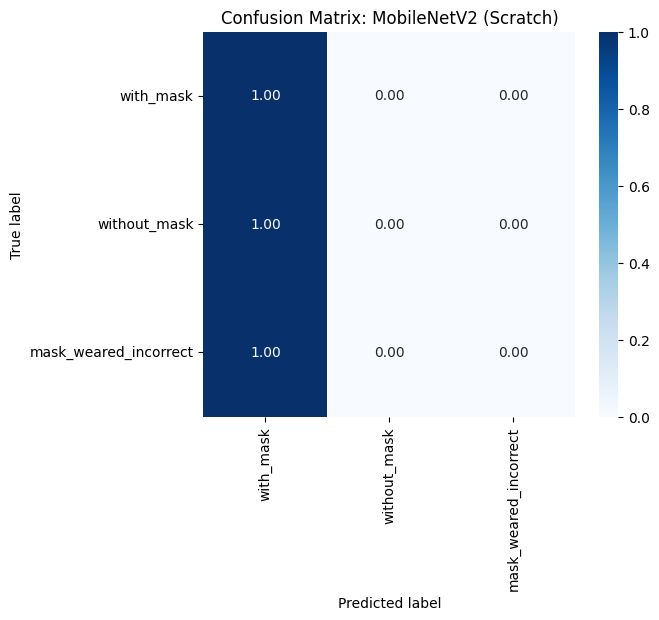

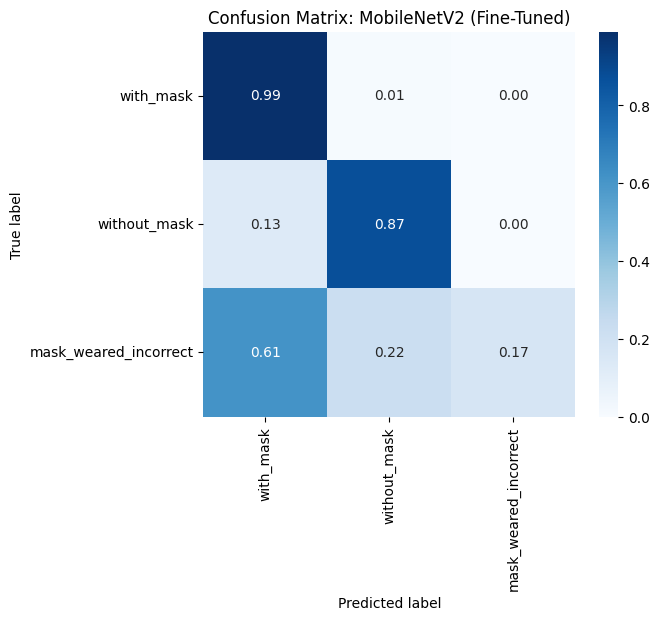

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', labels=['with_mask', 'without_mask', 'mask_weared_incorrect']):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Get predictions for each model
# 1. MobileNetV2 (Frozen)
predictions_mobilenet = model_mobilenet.predict(val_x)
predictions_mobilenet = np.argmax(predictions_mobilenet, axis=1)

# 2. MobileNetV2 (Scratch)
predictions_mobilenet_scratch = model_mobilenet_scratch.predict(val_x)
predictions_mobilenet_scratch = np.argmax(predictions_mobilenet_scratch, axis=1)

# 3. MobileNetV2 (Fine-Tuned)
predictions_mobilenet_finetune = model_mobilenet_finetune.predict(val_x)
predictions_mobilenet_finetune = np.argmax(predictions_mobilenet_finetune, axis=1)

# True labels
true_labels = np.argmax(val_y, axis=1)  # since val_y is one-hot encoded

# Plot confusion matrix for each model
plot_confusion_matrix(true_labels, predictions_mobilenet, title='Confusion Matrix: MobileNetV2 (Frozen)')
plot_confusion_matrix(true_labels, predictions_mobilenet_scratch, title='Confusion Matrix: MobileNetV2 (Scratch)')
plot_confusion_matrix(true_labels, predictions_mobilenet_finetune, title='Confusion Matrix: MobileNetV2 (Fine-Tuned)')
